<a href="https://colab.research.google.com/github/vondervish/Emotion_Detection_Roberta/blob/main/Vishala_Vemuri_Assignment_ROBERTA_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install transformers evaluate wandb datasets accelerate  -U -qq

    basepath = '/content/drive/MyDrive/Data'

else:
    basepath = '/C:/Users/Vishu/Downloads/Fall_2024/App_NLP'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

In [ ]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set seed before anything else
set_seed(42)

In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'emotion-detection-bert-fall-2024'
model_folder = base_folder/'Models/Emotion_detection_roberta_fall_2024'

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
model_folder

PosixPath('/content/drive/MyDrive/Data/Models/Emotion_detection_roberta_fall_2024')

In [ ]:
train_dataset = data_folder/'train.csv'
test_dataset = data_folder/'test.csv'

In [ ]:
import pandas as pd

In [ ]:
train_dataset = pd.read_csv(train_dataset)
test_dataset = pd.read_csv(test_dataset)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_dataset, valid_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

In [ ]:
train_dataset

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
4291,2017-20959,Going to get myself a copy of @StephenKing's C...,0,1,0,0,1,0,1,0,0,0,0
1210,2017-30404,@carysmithwriter @Maria_Savva @RealRockAndRoll...,0,0,0,0,1,1,1,0,0,0,0
1940,2017-20271,Unruly kids at 8am in the morning #nothanks ri...,1,0,1,1,0,0,0,0,0,1,0
6204,2017-10419,Ok but I just got called a 'White Devil' on th...,0,0,0,1,0,0,0,0,0,1,0
2867,2017-30687,@SXMUrbanView @karenhunter @CousinSyl you are ...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2017-31298,I've watched @ScreamQueens' 2nd Season's 1st e...,0,1,0,0,1,1,0,0,0,0,0
5390,2017-10158,Zero help from @ups customer service. Just pus...,1,0,1,0,0,0,0,0,0,0,0
860,2017-11048,#Scorpio always seek revenge!,1,0,1,0,0,0,0,1,0,0,0
7603,2018-04196,@jewleree @GameOfThrones Lmao night king smiles 😂,0,0,0,0,1,0,1,0,0,0,0


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install emoji

In [ ]:
!pip install contractions

In [ ]:
!pip install textblob
!pip install emot

In [ ]:
import spacy
from bs4 import BeautifulSoup
import re
import emoji
import contractions
from textblob import TextBlob
import emot

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Dictionary for expanding common slang
slang_dict = {
    "omg": "oh my god",
    "lol": "laugh out loud",
    "brb": "be right back",
    "smh": "shaking my head"
}

# Emoticons to emotion mapping
emoticons = emot.emo_unicode.EMOTICONS_EMO

# Function to reduce elongated words (e.g., "soooo" -> "soo")
def reduce_elongation(text):
    return re.sub(r'(.)\1+', r'\1\1', text)  # Reduces "soooo" to "soo"

# Function to expand slang terms using a dictionary
def expand_slang(text):
    return ' '.join([slang_dict.get(word, word) for word in text.split()])

# Function to handle negations (e.g., "not happy" -> "not_happy")
def handle_negations(text):
    words = text.split()
    new_words = []
    negation = False
    for word in words:
        if word in ['not', 'no', 'never']:
            negation = True
        elif negation:
            new_words.append(f'not_{word}')
            negation = False
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Main function for cleaning the text
def clean_for_emotion(text: str) -> str:
    # Step 1: Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Step 2: Normalize newlines and return characters
    text = re.sub(r'[\n\r]', ' ', text)

    # Step 3: Lowercase the text
    text = text.lower()

    # Step 4: Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions

    # Step 5: Remove special characters but keep punctuations like !, ?, $, %, /
    text = re.sub(r'[^\w\s!?$%/]', '', text)

    # Step 6: Expand contractions (e.g., "don't" -> "do not")
    text = contractions.fix(text)

    # Step 7: Expand slang (e.g., "lol" -> "laugh out loud")
    text = expand_slang(text)

    # Step 8: Handle elongated words (e.g., "soooo" -> "soo")
    text = reduce_elongation(text)

    # Step 9: Convert emojis to text using emoji library
    text = emoji.demojize(text)

    # Step 10: Convert emoticons to text (e.g., ":)" -> "happy")
    for emoticon, emotion in emoticons.items():
        text = text.replace(emoticon, emotion)


    # Step 12: Handle negations (e.g., "not happy" -> "not_happy")
    text = handle_negations(text)

    # Step 13: Remove excessive spaces
    text = re.sub(' +', ' ', text).strip()

    return text

In [ ]:
# Apply the cleaning function to the datasets
train_dataset['Tweet'] = [clean_for_emotion(text) for text in train_dataset['Tweet'].values]
valid_dataset['Tweet'] = [clean_for_emotion(text) for text in valid_dataset['Tweet'].values]
test_dataset['Tweet'] = [clean_for_emotion(text) for text in test_dataset['Tweet'].values]

<ipython-input-17-074558393167>:49: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
# Convert your original data to lists with float labels, replacing 'NONE' with 0.0
train_texts = train_dataset['Tweet'].tolist()
train_labels = train_dataset.iloc[:, 2:].replace('NONE', 0.0).astype(float).values.tolist()

valid_texts = valid_dataset['Tweet'].tolist()
valid_labels = valid_dataset.iloc[:, 2:].replace('NONE', 0.0).astype(float).values.tolist()

test_texts = test_dataset['Tweet'].tolist()
test_labels = test_dataset.iloc[:, 2:].replace('NONE', 0.0).astype(float).values.tolist()

In [ ]:
# Create Hugging Face Dataset objects directly from lists
trainset = Dataset.from_dict({
    'texts': train_texts,
    'labels': train_labels
})

validset = Dataset.from_dict({
    'texts': valid_texts,
    'labels': valid_labels
})

testset = Dataset.from_dict({
    'texts': test_texts,
    'labels': test_labels
})

In [ ]:
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise','trust']

In [ ]:
trainset[1]

{'texts': 'were the least known band in the world but so glad you asked muchlove',
 'labels': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]}

In [ ]:
trainset[1]['labels']

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Define tokenization function
def tokenize_function(example):
    return tokenizer(example["texts"], truncation=True)

# Apply tokenization to the datasets
trainset = trainset.map(tokenize_function, batched=True)
validset = validset.map(tokenize_function, batched=True)
testset = testset.map(tokenize_function, batched=True)

# Set format explicitly to ensure labels are in float format for Trainer compatibility
trainset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
validset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
testset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Verify that labels are now in float format
print(trainset[0]["labels"].dtype)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

torch.float32


In [ ]:
import torch

# Assuming 'trainset' has already been set up with 'labels' as a column
# Convert labels to tensor for easy manipulation
labels = torch.tensor(trainset['labels'], dtype=torch.float32)

# Count positive examples (1s) for each label (column-wise sum)
pos_counts = labels.sum(dim=0).cpu().numpy()

# Count negative examples (0s) for each label
neg_counts = labels.size(0) - pos_counts

# Calculate positional weights for each label
pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32)
print("Positional Weights for each label:", pos_weight)

Positional Weights for each label: tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])


<ipython-input-25-efd86ecd3992>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(trainset['labels'], dtype=torch.float32)


In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming 'trainset' contains your training data labels as a list or a pandas DataFrame column
labels = torch.tensor(trainset['labels']).to(device)  # Move labels to device

# Compute the number of positive and negative examples for each label
pos_counts = labels.sum(dim=0)  # Count of positive examples per label (1s)
neg_counts = labels.size(0) - pos_counts  # Count of negative examples per label (0s)

# Experiment with different alpha and max_weight values
alpha = 0.9  # Adjust alpha based on performance and label imbalance severity
max_weight = 4.0  # Adjust the max weight to prevent overly high weights

# Calculate dynamic pos_weight, focusing more on positive labels with a higher alpha value
pos_weight = alpha * (neg_counts / (pos_counts + 1e-5)) + (1 - alpha) * (1 / (pos_counts + 1e-5))

# Clamp pos_weight to avoid extreme values, ensuring no weight exceeds the specified max_weight
pos_weight = torch.clamp(pos_weight, max=max_weight)

# Move pos_weight to the same device as the model
pos_weight_tensor = pos_weight.float().to(device)

# Print pos_weight_tensor to verify
print("Positional Weights for each label:", pos_weight_tensor)

<ipython-input-26-f4f83be9d9ed>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(trainset['labels']).to(device)  # Move labels to device


Positional Weights for each label: tensor([1.5317, 4.0000, 1.4919, 4.0000, 1.4991, 4.0000, 2.0931, 4.0000, 2.1674,
        4.0000, 4.0000], device='cuda:0')


In [ ]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Get the device where the model is located
        device = model.device

        # Move labels to the correct device
        labels = inputs.get("labels").to(device)

        # Ensure pos_weight is on the same device
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # Move pos_weight to the device

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits.to(device)  # Move logits to the device (though they should be already)

        # Calculate the loss with positional weights
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Define the number of labels in your multi-label classification task
num_labels = 11  # Example: 11 labels for different emotions

# Load the model configuration with label mappings
config = AutoConfig.from_pretrained("roberta-base", num_labels=num_labels)
config.problem_type = "multi_label_classification"

# Initialize the model with the configuration
model_tweet_roberta = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    config=config
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=5,  # Number of training epochs
    per_device_train_batch_size=32,  # Batch size for training per device
    per_device_eval_batch_size=32,  # Batch size for evaluation per device
    weight_decay=0.05,  # Apply L2 regularization
    learning_rate=0.00005,  # Learning rate
    optim='adamw_torch',  # Optimizer

    lr_scheduler_type='linear',  # Type of scheduler; options include 'linear', 'cosine', etc.
    warmup_ratio=0.12,

    # Checkpoint saving and evaluation settings
    output_dir=str(model_folder),  # Output directory for checkpoints
    evaluation_strategy='steps',  # Evaluation strategy (steps)
    eval_steps=100,  # Evaluate every 100 steps
    save_strategy="steps",  # Save checkpoints at intervals
    save_steps=100,  # Save checkpoint every 100 steps
    load_best_model_at_end=True,  # Load best model at end of training
    save_total_limit=2,  # Keep only 2 checkpoints
    metric_for_best_model="f1",  # Metric for best model selection
    greater_is_better=True,  # Lower eval_loss is better

    # Logging settings
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics to Weights & Biases
    run_name="emotion_classification_experiment_roberta",  # Name for the experiment

    # Mixed-precision training for faster computation on GPUs
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score
import torch
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # Apply sigmoid to logits
    predictions = (probabilities > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

    f1 = f1_score(labels, predictions, average="macro")  # Calculate F1 score
    return {"f1": f1}

In [ ]:
# Initialize the custom trainer with all configurations
trainer = CustomTrainer(
    model=model_tweet_roberta,
    args=training_args,
    train_dataset=trainset,
    eval_dataset=validset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-31-bd0e36b314d2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
%env WANDB_PROJECT = Emotion_detection_roberta_fall_2024

env: WANDB_PROJECT=Emotion_detection_roberta_fall_2024


In [ ]:
# Train the model
trainer.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1
100,0.788900,0.675968,0.455652
200,0.622100,0.575133,0.560791
300,0.540800,0.578127,0.552336
400,0.528200,0.569526,0.562862
500,0.462400,0.545852,0.579799
600,0.441400,0.536687,0.599343
700,0.396600,0.546460,0.591291
800,0.382000,0.546679,0.599052
900,0.349100,0.548674,0.591691


TrainOutput(global_step=970, training_loss=0.49015351718234035, metrics={'train_runtime': 329.6604, 'train_samples_per_second': 93.718, 'train_steps_per_second': 2.942, 'total_flos': 564283141660656.0, 'train_loss': 0.49015351718234035, 'epoch': 5.0})

In [ ]:
# Evaluate the model on the validation dataset
eval_results = trainer.evaluate(eval_dataset=validset)

# Print the evaluation results
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.5366873145103455, 'eval_f1': 0.5993429259173699, 'eval_runtime': 1.2865, 'eval_samples_per_second': 1200.907, 'eval_steps_per_second': 38.087, 'epoch': 5.0}


In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 600.


In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(validset)

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [ ]:
optimal_thresholds

[0.38121962547302246,
 0.5325618982315063,
 0.3572871685028076,
 0.7887459397315979,
 0.41774851083755493,
 0.6897218227386475,
 0.5476454496383667,
 0.5656286478042603,
 0.49967408180236816,
 0.44999679923057556,
 0.5981947779655457]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6978361669242659,
 'f1_macro': 0.6184752027930999,
 'accuracy_label': 0.8619593998234775,
 'accuracy_all': 0.2226537216828479}

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 826  147]
  [  91  481]]

 [[1132  191]
  [ 105  117]]

 [[ 746  203]
  [ 116  480]]

 [[1183   57]
  [  82  223]]

 [[ 875  111]
  [  97  462]]

 [[1314   80]
  [  48  103]]

 [[ 897  215]
  [  68  365]]

 [[1235  123]
  [  92   95]]

 [[ 910  175]
  [ 138  322]]

 [[1435   40]
  [  42   28]]

 [[1387   66]
  [  59   33]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

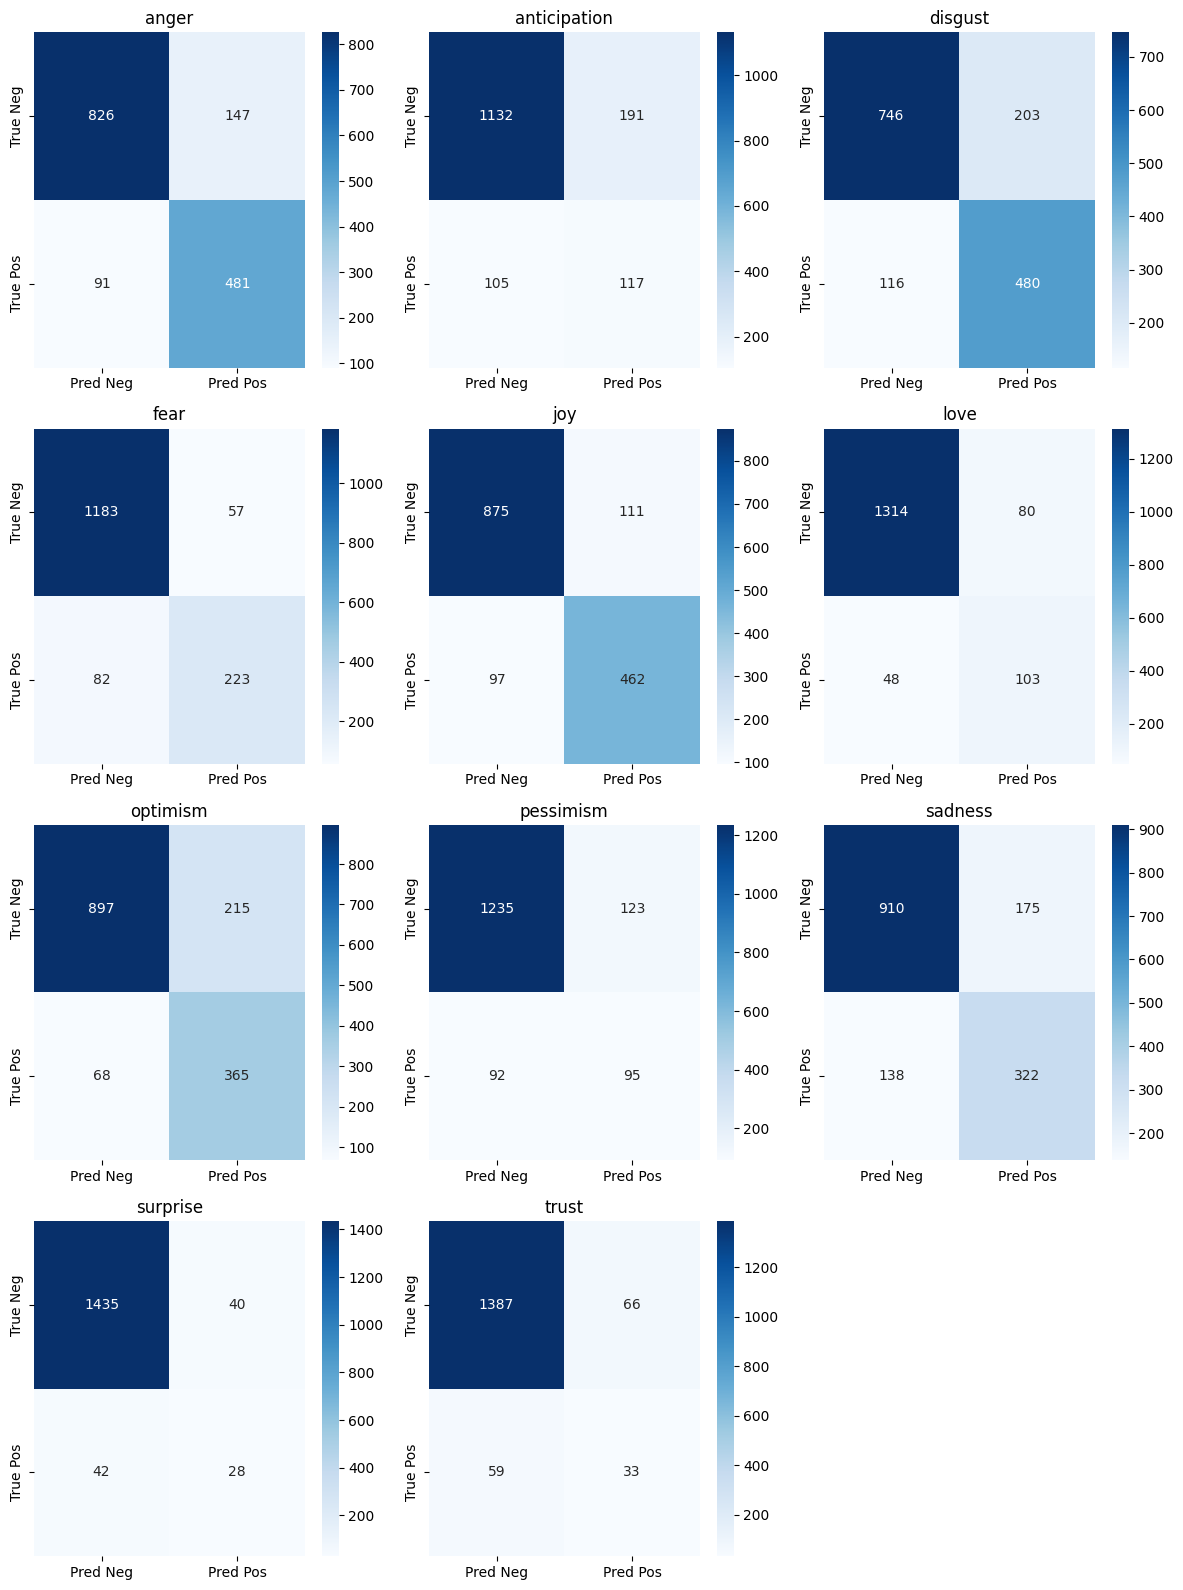

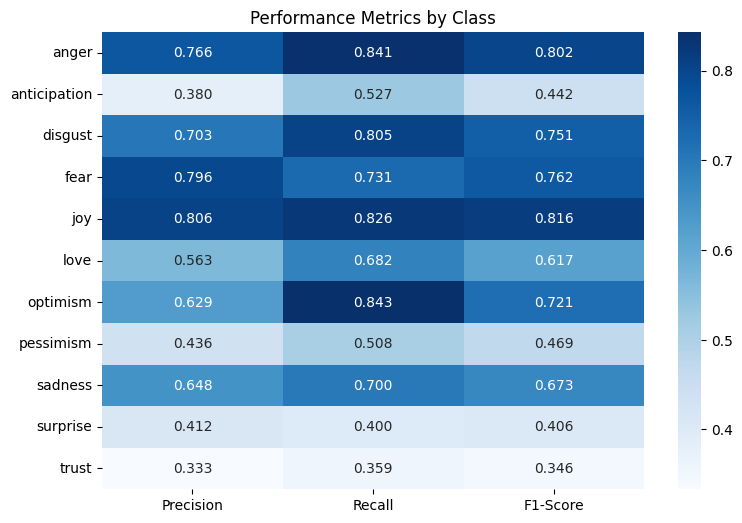

<Figure size 1200x533.333 with 0 Axes>

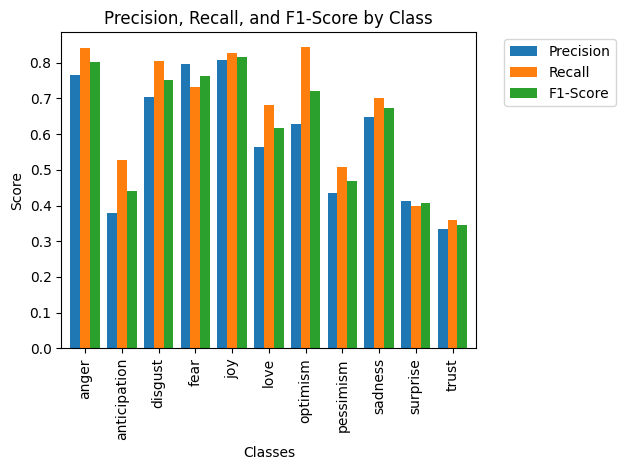

{'macro_avg': {'precision': 0.5883821718225867,
  'recall': 0.6566110003733457,
  'f1': 0.6184752027930999},
 'per_class': {'Precision': {'anger': 0.7659235668789809,
   'anticipation': 0.37987012987012986,
   'disgust': 0.7027818448023426,
   'fear': 0.7964285714285714,
   'joy': 0.806282722513089,
   'love': 0.5628415300546448,
   'optimism': 0.6293103448275862,
   'pessimism': 0.43577981651376146,
   'sadness': 0.647887323943662,
   'surprise': 0.4117647058823529,
   'trust': 0.3333333333333333},
  'Recall': {'anger': 0.8409090909090909,
   'anticipation': 0.527027027027027,
   'disgust': 0.8053691275167785,
   'fear': 0.7311475409836066,
   'joy': 0.8264758497316637,
   'love': 0.6821192052980133,
   'optimism': 0.8429561200923787,
   'pessimism': 0.5080213903743316,
   'sadness': 0.7,
   'surprise': 0.4,
   'trust': 0.358695652173913},
  'F1-Score': {'anger': 0.8016666666666666,
   'anticipation': 0.44150943396226416,
   'disgust': 0.7505863956215794,
   'fear': 0.7623931623931623

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [ ]:
wandb.finish()

eval/f1,▁▆▆▆▇█████
eval/loss,█▃▃▃▁▁▁▂▂▁
eval/runtime,▇▆▄▄█▅▄▁▂▃
eval/samples_per_second,▁▂▄▄▁▃▄█▆▅
eval/steps_per_second,▁▂▄▄▁▃▄█▆▅
test/f1,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▇▇▇▇██


In [ ]:
import wandb

# Initialize wandb for logging (replace 'your_project_name' with your project name)
wandb.init(project="Emotion_detection_roberta_fall_2024", name="emotion_classification_experiment_roberta")


wandb: Currently logged in as: vondervish (vondervish-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model checkpoint and move it to the appropriate device
best_model_checkpoint = trainer.state.best_model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(best_model_checkpoint).to(device)

# Update the trainer to use the model on the correct device
trainer.model = model

# Ensure testset is compatible with the device
testset = testset.map(lambda x: {k: v.to(device) for k, v in x.items() if torch.is_tensor(v)})

# Make predictions on the test set
predictions = trainer.predict(test_dataset=testset)

# Extract logits from the prediction output
logits = predictions.predictions

# Apply sigmoid to convert logits to probabilities for multi-label classification
probabilities = torch.sigmoid(torch.tensor(logits)).numpy()

# Apply optimal thresholds for each label to generate binary predictions
# Assuming optimal_thresholds is a list with one threshold per label
binary_predictions = (probabilities > optimal_thresholds).astype(int)

# Display the predictions
print("Predicted binary labels for the test set:\n", binary_predictions)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Predicted binary labels for the test set:
 [[1 0 0 ... 0 0 0]
 [1 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]]


In [ ]:
test_predictions = pd.DataFrame(binary_predictions)
# Use pd.concat to concatenate the DataFrames
test_predictions = pd.concat([test_dataset['ID'],test_predictions], axis=1)

In [ ]:
test_predictions.to_csv('test_predictions_roberta.csv', index=False)